# Radial basis function for continuos state approximation SARSA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
class MountainCar(object):
    def __init__(self,alpha=0.01, gamma=0.999, epsilon= 0.1, Lambda=0.55):
        super(MountainCar, self).__init__()          
        self.alpha       = alpha    #learning rate
        self.gamma       = gamma    #discount factor
        self.epsilon     = epsilon  #probability of a random action selection
        self.Lambda      = Lambda 
        self.actionlist  = self.BuildActionList()   # the list of actions        
        self.nactions    = self.actionlist.shape[0] # number of actions      
        self.num_rbf = 4 * np.ones(self.nactions).astype(int)
        self.width = 1. / (self.num_rbf - 1.)
        self.rbf_sigma = self.width[0] / 2.
        self.num_ind = np.prod(self.num_rbf)
        self.rbf_den = 2 * self.rbf_sigma ** 2  
        self.centres = self.BuildCenters()
        
    def BuildActionList(self):
        return np.array([-1.0 , 0.0 , 1.0])

    def normalize_state(self, _s):
        xbar = np.zeros((2, 2))
        xbar[0, :] = (0.5, 0.07)
        xbar[1, :] = (-1.5, -0.07)
        _y = np.zeros(len(_s))
        for _i in range(len(_s)):
            _y[_i] = (_s[_i] - xbar[0, _i]) / (xbar[1, _i] - xbar[0, _i])
        return _y

    def BuildCenters(self):
        c = np.zeros((self.num_ind, 2))
        for i in range(self.num_rbf[0]):
            for j in range(self.num_rbf[1]):
                c[i*self.num_rbf[1] + j, :] = (i * self.width[1], j * self.width[0])
        return c

    def GetReward(self, x ):
        # MountainCarGetReward returns the reward at the current state
        # x: a vector of position and velocity of the car
        # r: the returned reward.
        # f: true if the car reached the goal, otherwise f is false
            
        position = x[0]
        # bound for position; the goal is to reach position = 0.45
        bpright  = 0.45

        r = -1
        f = False
        
        
        if  position >= bpright:
            r = 100
            f = True
        
        return r,f

    
    def DoAction(self, force, x ):
        #MountainCarDoAction: executes the action (a) into the mountain car
        # a: is the force to be applied to the car
        # x: is the vector containning the position and speed of the car
        # xp: is the vector containing the new position and velocity of the car

        position = x[0]
        speed    = x[1] 

        # bounds for position
        bpleft=-1.5 

        # bounds for speed
        bsleft=-0.07 
        bsright=0.07
         
        speedt1= speed + (0.001*force) + (-0.0025 * math.cos( 3.0*position) )	 
        speedt1= speedt1 * 0.999 # thermodynamic law, for a more real system with friction.

        if speedt1<bsleft: 
            speedt1=bsleft 
        elif speedt1>bsright:
            speedt1=bsright    

        post1 = position + speedt1 

        if post1<=bpleft:
            post1=bpleft
            speedt1=0.0
            
        xp = np.array([post1,speedt1])
        return xp


    def GetInitialState(self):
        initial_position = -0.5
        initial_speed    =  0.0    
        return  np.array([initial_position,initial_speed])

    def phi(self, _state):
        _phi = np.zeros(self.num_ind)
        for _k in range(self.num_ind):
            _phi[_k] = np.exp(-np.linalg.norm(_state - self.centres[_k, :]) ** 2 / self.rbf_den)
        return _phi
        
    def GetBestAction(self, s, theta):
        #GetBestAction return the best action for state (s)
        #Q: the Qtable
        #the current state
        #has structure  Q(states,actions)
        
        #a = argmax(self.Q[s,:].flat)
        a  = np.argmax(self.action_values(s, theta))    
        return a
    
    def action_values(self, _activations, _theta):
        _val = np.dot(_theta.T, _activations)
        return _val

    def action_value(self, _activations, _action, _theta):
        _val = np.dot(_theta[:, _action], _activations)
        return _val

    def epsilon_greedy(self, _epsilon, _vals):
        _rand = np.random.random()
        if _rand < 1. - _epsilon:
            _action = _vals.argmax()
        else:
            _action = random.randint(0, 2)
        #print(int(_action))
        return int(_action)

    def SARSAEpisode(self, maxsteps, theta):
        # do one episode with sarsa learning
        # maxstepts: the maximum number of steps per episode
        # Q: the current QTable
        # alpha: the current learning rate
        # gamma: the current discount factor
        # epsilon: probablity of a random action
        # statelist: the list of states
        # actionlist: the list of actions
        
        e = np.zeros((self.num_ind, self.nactions))
        x                = self.GetInitialState()
        steps            = 0
        total_reward     = 0
        
        # convert the continous state variables to an index of the statelist
        
        s  = self.phi(self.normalize_state(x))
        vals = self.action_values(s, theta)
        #print(vals)
        # selects an action using the epsilon greedy selection strategy
        a = self.epsilon_greedy(self.epsilon, vals)

        for i in range(maxsteps):
                        
            # convert the index of the action into an action value
            action = self.actionlist[a]    
            
            # do the selected action and get the next car state    
            xp     = self.DoAction( action , x )    
            
            # observe the reward at state xp and the final state flag
            r, isfinal    = self.GetReward(xp)
            total_reward = total_reward + r

            # convert the continous state variables in [xp] to an index of the statelist
            sp     = self.phi(self.normalize_state(xp))

            new_vals = self.action_values(sp, theta)
            # select action prime
            ap     = self.epsilon_greedy(self.epsilon, new_vals)
            #print(ap)

            Q = self.action_value(s, a, theta)
            Q_new = self.action_value(sp, ap, theta)

            if isfinal==True:
                target = r - Q
            else:
                target = r + self.gamma * Q_new - Q

            e[:, a] = s

            # Update the Qtable, that is,  learn from the experience
            for k in range(self.num_ind):
                for a in range(self.nactions):
                    theta[k, a] += self.alpha * target * e[k, a]
            
            e *= self.gamma * self.Lambda

            #update the current variables
            s = sp.copy()
            a = ap
            x = xp.copy()
                
            
            #increment the step counter.
            steps = steps+1
            
            # if reachs the goal breaks the episode
            if isfinal==True:
                break
        
        return total_reward, steps, theta

In [3]:
def MountainCarDemo(maxepisodes):
    MC  = MountainCar()
    maxsteps = 1000
    theta = np.zeros((64,3))
    xpoints=[]
    ypoints=[]

    for i in range(maxepisodes):    
        total_reward,steps, theta_prime = MC.SARSAEpisode( maxsteps, theta)    
        MC.epsilon = MC.epsilon * 0.9999
        theta = theta_prime

        print ('Espisode: ',i,'  Steps:',steps,'  Reward:',str(total_reward),' epsilon: ',str(MC.epsilon))
        xpoints.append(i)
        ypoints.append(-total_reward)

    plt.plot(xpoints, ypoints)
    plt.xlabel("Episodes")
    plt.ylabel("-Rewards")
    plt.show()

Espisode:  0   Steps: 1000   Reward: -1000  epsilon:  0.09999000000000001
Espisode:  1   Steps: 1000   Reward: -1000  epsilon:  0.09998000100000001
Espisode:  2   Steps: 1000   Reward: -1000  epsilon:  0.09997000299990001
Espisode:  3   Steps: 1000   Reward: -1000  epsilon:  0.09996000599960002
Espisode:  4   Steps: 1000   Reward: -1000  epsilon:  0.09995000999900006
Espisode:  5   Steps: 1000   Reward: -1000  epsilon:  0.09994001499800016
Espisode:  6   Steps: 1000   Reward: -1000  epsilon:  0.09993002099650036
Espisode:  7   Steps: 987   Reward: -886  epsilon:  0.09992002799440071
Espisode:  8   Steps: 1000   Reward: -1000  epsilon:  0.09991003599160127
Espisode:  9   Steps: 1000   Reward: -1000  epsilon:  0.0999000449880021
Espisode:  10   Steps: 849   Reward: -748  epsilon:  0.0998900549835033
Espisode:  11   Steps: 1000   Reward: -1000  epsilon:  0.09988006597800494
Espisode:  12   Steps: 689   Reward: -588  epsilon:  0.09987007797140715
Espisode:  13   Steps: 1000   Reward: -1000

Espisode:  114   Steps: 297   Reward: -196  epsilon:  0.0988565303784803
Espisode:  115   Steps: 302   Reward: -201  epsilon:  0.09884664472544245
Espisode:  116   Steps: 264   Reward: -163  epsilon:  0.0988367600609699
Espisode:  117   Steps: 337   Reward: -236  epsilon:  0.0988268763849638
Espisode:  118   Steps: 315   Reward: -214  epsilon:  0.09881699369732531
Espisode:  119   Steps: 320   Reward: -219  epsilon:  0.09880711199795558
Espisode:  120   Steps: 380   Reward: -279  epsilon:  0.09879723128675579
Espisode:  121   Steps: 294   Reward: -193  epsilon:  0.09878735156362711
Espisode:  122   Steps: 322   Reward: -221  epsilon:  0.09877747282847076
Espisode:  123   Steps: 339   Reward: -238  epsilon:  0.0987675950811879
Espisode:  124   Steps: 270   Reward: -169  epsilon:  0.09875771832167979
Espisode:  125   Steps: 345   Reward: -244  epsilon:  0.09874784254984763
Espisode:  126   Steps: 343   Reward: -242  epsilon:  0.09873796776559264
Espisode:  127   Steps: 322   Reward: -221

Espisode:  227   Steps: 289   Reward: -188  epsilon:  0.09774568414408598
Espisode:  228   Steps: 180   Reward: -79  epsilon:  0.09773590957567158
Espisode:  229   Steps: 289   Reward: -188  epsilon:  0.09772613598471401
Espisode:  230   Steps: 188   Reward: -87  epsilon:  0.09771636337111554
Espisode:  231   Steps: 182   Reward: -81  epsilon:  0.09770659173477843
Espisode:  232   Steps: 181   Reward: -80  epsilon:  0.09769682107560496
Espisode:  233   Steps: 205   Reward: -104  epsilon:  0.0976870513934974
Espisode:  234   Steps: 178   Reward: -77  epsilon:  0.09767728268835806
Espisode:  235   Steps: 236   Reward: -135  epsilon:  0.09766751496008923
Espisode:  236   Steps: 177   Reward: -76  epsilon:  0.09765774820859321
Espisode:  237   Steps: 287   Reward: -186  epsilon:  0.09764798243377236
Espisode:  238   Steps: 178   Reward: -77  epsilon:  0.09763821763552899
Espisode:  239   Steps: 183   Reward: -82  epsilon:  0.09762845381376543
Espisode:  240   Steps: 205   Reward: -104  eps

Espisode:  340   Steps: 245   Reward: -144  epsilon:  0.09664732043716608
Espisode:  341   Steps: 159   Reward: -58  epsilon:  0.09663765570512237
Espisode:  342   Steps: 199   Reward: -98  epsilon:  0.09662799193955185
Espisode:  343   Steps: 174   Reward: -73  epsilon:  0.0966183291403579
Espisode:  344   Steps: 191   Reward: -90  epsilon:  0.09660866730744386
Espisode:  345   Steps: 260   Reward: -159  epsilon:  0.09659900644071312
Espisode:  346   Steps: 274   Reward: -173  epsilon:  0.09658934654006905
Espisode:  347   Steps: 231   Reward: -130  epsilon:  0.09657968760541505
Espisode:  348   Steps: 163   Reward: -62  epsilon:  0.09657002963665451
Espisode:  349   Steps: 324   Reward: -223  epsilon:  0.09656037263369084
Espisode:  350   Steps: 158   Reward: -57  epsilon:  0.09655071659642747
Espisode:  351   Steps: 196   Reward: -95  epsilon:  0.09654106152476782
Espisode:  352   Steps: 177   Reward: -76  epsilon:  0.09653140741861535
Espisode:  353   Steps: 268   Reward: -167  eps

Espisode:  453   Steps: 185   Reward: -84  epsilon:  0.09556129899213973
Espisode:  454   Steps: 187   Reward: -86  epsilon:  0.09555174286224052
Espisode:  455   Steps: 208   Reward: -107  epsilon:  0.0955421876879543
Espisode:  456   Steps: 187   Reward: -86  epsilon:  0.09553263346918552
Espisode:  457   Steps: 197   Reward: -96  epsilon:  0.09552308020583859
Espisode:  458   Steps: 286   Reward: -185  epsilon:  0.09551352789781802
Espisode:  459   Steps: 281   Reward: -180  epsilon:  0.09550397654502824
Espisode:  460   Steps: 274   Reward: -173  epsilon:  0.09549442614737373
Espisode:  461   Steps: 173   Reward: -72  epsilon:  0.095484876704759
Espisode:  462   Steps: 300   Reward: -199  epsilon:  0.09547532821708853
Espisode:  463   Steps: 193   Reward: -92  epsilon:  0.09546578068426682
Espisode:  464   Steps: 294   Reward: -193  epsilon:  0.0954562341061984
Espisode:  465   Steps: 171   Reward: -70  epsilon:  0.09544668848278778
Espisode:  466   Steps: 268   Reward: -167  epsil

Espisode:  566   Steps: 186   Reward: -85  epsilon:  0.09448748111958417
Espisode:  567   Steps: 188   Reward: -87  epsilon:  0.09447803237147222
Espisode:  568   Steps: 184   Reward: -83  epsilon:  0.09446858456823506
Espisode:  569   Steps: 180   Reward: -79  epsilon:  0.09445913770977825
Espisode:  570   Steps: 188   Reward: -87  epsilon:  0.09444969179600728
Espisode:  571   Steps: 181   Reward: -80  epsilon:  0.09444024682682768
Espisode:  572   Steps: 179   Reward: -78  epsilon:  0.094430802802145
Espisode:  573   Steps: 184   Reward: -83  epsilon:  0.09442135972186479
Espisode:  574   Steps: 184   Reward: -83  epsilon:  0.0944119175858926
Espisode:  575   Steps: 200   Reward: -99  epsilon:  0.094402476394134
Espisode:  576   Steps: 190   Reward: -89  epsilon:  0.0943930361464946
Espisode:  577   Steps: 187   Reward: -86  epsilon:  0.09438359684287995
Espisode:  578   Steps: 201   Reward: -100  epsilon:  0.09437415848319566
Espisode:  579   Steps: 187   Reward: -86  epsilon:  0.0

Espisode:  679   Steps: 189   Reward: -88  epsilon:  0.09342572968852303
Espisode:  680   Steps: 201   Reward: -100  epsilon:  0.09341638711555418
Espisode:  681   Steps: 287   Reward: -186  epsilon:  0.09340704547684263
Espisode:  682   Steps: 175   Reward: -74  epsilon:  0.09339770477229495
Espisode:  683   Steps: 188   Reward: -87  epsilon:  0.09338836500181771
Espisode:  684   Steps: 189   Reward: -88  epsilon:  0.09337902616531753
Espisode:  685   Steps: 186   Reward: -85  epsilon:  0.09336968826270099
Espisode:  686   Steps: 172   Reward: -71  epsilon:  0.09336035129387472
Espisode:  687   Steps: 191   Reward: -90  epsilon:  0.09335101525874534
Espisode:  688   Steps: 164   Reward: -63  epsilon:  0.09334168015721947
Espisode:  689   Steps: 172   Reward: -71  epsilon:  0.09333234598920374
Espisode:  690   Steps: 186   Reward: -85  epsilon:  0.09332301275460482
Espisode:  691   Steps: 184   Reward: -83  epsilon:  0.09331368045332936
Espisode:  692   Steps: 178   Reward: -77  epsilo

Espisode:  791   Steps: 193   Reward: -92  epsilon:  0.0923851476236767
Espisode:  792   Steps: 187   Reward: -86  epsilon:  0.09237590910891433
Espisode:  793   Steps: 199   Reward: -98  epsilon:  0.09236667151800344
Espisode:  794   Steps: 196   Reward: -95  epsilon:  0.09235743485085164
Espisode:  795   Steps: 184   Reward: -83  epsilon:  0.09234819910736655
Espisode:  796   Steps: 193   Reward: -92  epsilon:  0.09233896428745582
Espisode:  797   Steps: 198   Reward: -97  epsilon:  0.09232973039102707
Espisode:  798   Steps: 202   Reward: -101  epsilon:  0.09232049741798797
Espisode:  799   Steps: 214   Reward: -113  epsilon:  0.09231126536824617
Espisode:  800   Steps: 194   Reward: -93  epsilon:  0.09230203424170935
Espisode:  801   Steps: 212   Reward: -111  epsilon:  0.09229280403828519
Espisode:  802   Steps: 233   Reward: -132  epsilon:  0.09228357475788136
Espisode:  803   Steps: 200   Reward: -99  epsilon:  0.09227434640040558
Espisode:  804   Steps: 235   Reward: -134  epsi

Espisode:  904   Steps: 210   Reward: -109  epsilon:  0.09134702001633693
Espisode:  905   Steps: 238   Reward: -137  epsilon:  0.0913378853143353
Espisode:  906   Steps: 205   Reward: -104  epsilon:  0.09132875152580387
Espisode:  907   Steps: 211   Reward: -110  epsilon:  0.09131961865065129
Espisode:  908   Steps: 197   Reward: -96  epsilon:  0.09131048668878622
Espisode:  909   Steps: 207   Reward: -106  epsilon:  0.09130135564011733
Espisode:  910   Steps: 193   Reward: -92  epsilon:  0.09129222550455332
Espisode:  911   Steps: 213   Reward: -112  epsilon:  0.09128309628200286
Espisode:  912   Steps: 193   Reward: -92  epsilon:  0.09127396797237466
Espisode:  913   Steps: 205   Reward: -104  epsilon:  0.09126484057557743
Espisode:  914   Steps: 218   Reward: -117  epsilon:  0.09125571409151988
Espisode:  915   Steps: 208   Reward: -107  epsilon:  0.09124658852011072
Espisode:  916   Steps: 211   Reward: -110  epsilon:  0.09123746386125871
Espisode:  917   Steps: 211   Reward: -110

Espisode:  1016   Steps: 216   Reward: -115  epsilon:  0.09032959075971712
Espisode:  1017   Steps: 225   Reward: -124  epsilon:  0.09032055780064115
Espisode:  1018   Steps: 191   Reward: -90  epsilon:  0.09031152574486108
Espisode:  1019   Steps: 209   Reward: -108  epsilon:  0.09030249459228659
Espisode:  1020   Steps: 233   Reward: -132  epsilon:  0.09029346434282737
Espisode:  1021   Steps: 208   Reward: -107  epsilon:  0.09028443499639309
Espisode:  1022   Steps: 232   Reward: -131  epsilon:  0.09027540655289346
Espisode:  1023   Steps: 198   Reward: -97  epsilon:  0.09026637901223816
Espisode:  1024   Steps: 198   Reward: -97  epsilon:  0.09025735237433694
Espisode:  1025   Steps: 207   Reward: -106  epsilon:  0.0902483266390995
Espisode:  1026   Steps: 199   Reward: -98  epsilon:  0.09023930180643559
Espisode:  1027   Steps: 216   Reward: -115  epsilon:  0.09023027787625496
Espisode:  1028   Steps: 201   Reward: -100  epsilon:  0.09022125484846732
Espisode:  1029   Steps: 238  

Espisode:  1127   Steps: 185   Reward: -84  epsilon:  0.0893324269413249
Espisode:  1128   Steps: 199   Reward: -98  epsilon:  0.08932349369863077
Espisode:  1129   Steps: 197   Reward: -96  epsilon:  0.08931456134926091
Espisode:  1130   Steps: 252   Reward: -151  epsilon:  0.08930562989312599
Espisode:  1131   Steps: 223   Reward: -122  epsilon:  0.08929669933013668
Espisode:  1132   Steps: 201   Reward: -100  epsilon:  0.08928776966020366
Espisode:  1133   Steps: 202   Reward: -101  epsilon:  0.08927884088323763
Espisode:  1134   Steps: 188   Reward: -87  epsilon:  0.08926991299914931
Espisode:  1135   Steps: 194   Reward: -93  epsilon:  0.0892609860078494
Espisode:  1136   Steps: 194   Reward: -93  epsilon:  0.08925205990924862
Espisode:  1137   Steps: 234   Reward: -133  epsilon:  0.08924313470325769
Espisode:  1138   Steps: 190   Reward: -89  epsilon:  0.08923421038978736
Espisode:  1139   Steps: 193   Reward: -92  epsilon:  0.08922528696874839
Espisode:  1140   Steps: 204   Rewa

Espisode:  1237   Steps: 241   Reward: -140  epsilon:  0.08835510649570529
Espisode:  1238   Steps: 234   Reward: -133  epsilon:  0.08834627098505572
Espisode:  1239   Steps: 244   Reward: -143  epsilon:  0.08833743635795721
Espisode:  1240   Steps: 263   Reward: -162  epsilon:  0.08832860261432142
Espisode:  1241   Steps: 236   Reward: -135  epsilon:  0.08831976975405999
Espisode:  1242   Steps: 236   Reward: -135  epsilon:  0.08831093777708458
Espisode:  1243   Steps: 310   Reward: -209  epsilon:  0.08830210668330687
Espisode:  1244   Steps: 248   Reward: -147  epsilon:  0.08829327647263854
Espisode:  1245   Steps: 239   Reward: -138  epsilon:  0.08828444714499128
Espisode:  1246   Steps: 232   Reward: -131  epsilon:  0.08827561870027678
Espisode:  1247   Steps: 230   Reward: -129  epsilon:  0.08826679113840676
Espisode:  1248   Steps: 253   Reward: -152  epsilon:  0.08825796445929292
Espisode:  1249   Steps: 330   Reward: -229  epsilon:  0.08824913866284699
Espisode:  1250   Steps: 

Espisode:  1347   Steps: 217   Reward: -116  epsilon:  0.08738847819498909
Espisode:  1348   Steps: 229   Reward: -128  epsilon:  0.08737973934716958
Espisode:  1349   Steps: 244   Reward: -143  epsilon:  0.08737100137323486
Espisode:  1350   Steps: 272   Reward: -171  epsilon:  0.08736226427309754
Espisode:  1351   Steps: 232   Reward: -131  epsilon:  0.08735352804667024
Espisode:  1352   Steps: 278   Reward: -177  epsilon:  0.08734479269386557
Espisode:  1353   Steps: 228   Reward: -127  epsilon:  0.08733605821459618
Espisode:  1354   Steps: 225   Reward: -124  epsilon:  0.08732732460877472
Espisode:  1355   Steps: 243   Reward: -142  epsilon:  0.08731859187631384
Espisode:  1356   Steps: 217   Reward: -116  epsilon:  0.0873098600171262
Espisode:  1357   Steps: 236   Reward: -135  epsilon:  0.0873011290311245
Espisode:  1358   Steps: 230   Reward: -129  epsilon:  0.08729239891822138
Espisode:  1359   Steps: 229   Reward: -128  epsilon:  0.08728366967832955
Espisode:  1360   Steps: 21

Espisode:  1458   Steps: 125   Reward: -24  epsilon:  0.08642378182176848
Espisode:  1459   Steps: 130   Reward: -29  epsilon:  0.08641513944358631
Espisode:  1460   Steps: 126   Reward: -25  epsilon:  0.08640649792964195
Espisode:  1461   Steps: 124   Reward: -23  epsilon:  0.08639785727984899
Espisode:  1462   Steps: 124   Reward: -23  epsilon:  0.086389217494121
Espisode:  1463   Steps: 129   Reward: -28  epsilon:  0.0863805785723716
Espisode:  1464   Steps: 123   Reward: -22  epsilon:  0.08637194051451436
Espisode:  1465   Steps: 129   Reward: -28  epsilon:  0.08636330332046291
Espisode:  1466   Steps: 125   Reward: -24  epsilon:  0.08635466699013086
Espisode:  1467   Steps: 124   Reward: -23  epsilon:  0.08634603152343186
Espisode:  1468   Steps: 120   Reward: -19  epsilon:  0.08633739692027952
Espisode:  1469   Steps: 123   Reward: -22  epsilon:  0.08632876318058749
Espisode:  1470   Steps: 122   Reward: -21  epsilon:  0.08632013030426944
Espisode:  1471   Steps: 112   Reward: -1

Espisode:  1570   Steps: 175   Reward: -74  epsilon:  0.08546118792349505
Espisode:  1571   Steps: 164   Reward: -63  epsilon:  0.0854526418047027
Espisode:  1572   Steps: 168   Reward: -67  epsilon:  0.08544409654052224
Espisode:  1573   Steps: 163   Reward: -62  epsilon:  0.08543555213086819
Espisode:  1574   Steps: 189   Reward: -88  epsilon:  0.0854270085756551
Espisode:  1575   Steps: 160   Reward: -59  epsilon:  0.08541846587479754
Espisode:  1576   Steps: 190   Reward: -89  epsilon:  0.08540992402821006
Espisode:  1577   Steps: 169   Reward: -68  epsilon:  0.08540138303580724
Espisode:  1578   Steps: 168   Reward: -67  epsilon:  0.08539284289750367
Espisode:  1579   Steps: 160   Reward: -59  epsilon:  0.08538430361321392
Espisode:  1580   Steps: 159   Reward: -58  epsilon:  0.0853757651828526
Espisode:  1581   Steps: 162   Reward: -61  epsilon:  0.08536722760633432
Espisode:  1582   Steps: 164   Reward: -63  epsilon:  0.08535869088357369
Espisode:  1583   Steps: 179   Reward: -7

Espisode:  1682   Steps: 159   Reward: -58  epsilon:  0.08450931546084332
Espisode:  1683   Steps: 144   Reward: -43  epsilon:  0.08450086452929724
Espisode:  1684   Steps: 148   Reward: -47  epsilon:  0.0844924144428443
Espisode:  1685   Steps: 144   Reward: -43  epsilon:  0.08448396520140002
Espisode:  1686   Steps: 155   Reward: -54  epsilon:  0.08447551680487987
Espisode:  1687   Steps: 148   Reward: -47  epsilon:  0.08446706925319938
Espisode:  1688   Steps: 197   Reward: -96  epsilon:  0.08445862254627406
Espisode:  1689   Steps: 156   Reward: -55  epsilon:  0.08445017668401944
Espisode:  1690   Steps: 149   Reward: -48  epsilon:  0.08444173166635104
Espisode:  1691   Steps: 146   Reward: -45  epsilon:  0.0844332874931844
Espisode:  1692   Steps: 151   Reward: -50  epsilon:  0.08442484416443509
Espisode:  1693   Steps: 238   Reward: -137  epsilon:  0.08441640168001864
Espisode:  1694   Steps: 150   Reward: -49  epsilon:  0.08440796003985064
Espisode:  1695   Steps: 150   Reward: 

Espisode:  1794   Steps: 147   Reward: -46  epsilon:  0.08356804501774186
Espisode:  1795   Steps: 155   Reward: -54  epsilon:  0.08355968821324009
Espisode:  1796   Steps: 152   Reward: -51  epsilon:  0.08355133224441877
Espisode:  1797   Steps: 152   Reward: -51  epsilon:  0.08354297711119432
Espisode:  1798   Steps: 258   Reward: -157  epsilon:  0.0835346228134832
Espisode:  1799   Steps: 148   Reward: -47  epsilon:  0.08352626935120186
Espisode:  1800   Steps: 151   Reward: -50  epsilon:  0.08351791672426674
Espisode:  1801   Steps: 173   Reward: -72  epsilon:  0.08350956493259432
Espisode:  1802   Steps: 149   Reward: -48  epsilon:  0.08350121397610105
Espisode:  1803   Steps: 147   Reward: -46  epsilon:  0.08349286385470345
Espisode:  1804   Steps: 150   Reward: -49  epsilon:  0.08348451456831797
Espisode:  1805   Steps: 151   Reward: -50  epsilon:  0.08347616611686114
Espisode:  1806   Steps: 150   Reward: -49  epsilon:  0.08346781850024945
Espisode:  1807   Steps: 153   Reward:

Espisode:  1905   Steps: 329   Reward: -228  epsilon:  0.08264552306048946
Espisode:  1906   Steps: 219   Reward: -118  epsilon:  0.08263725850818342
Espisode:  1907   Steps: 160   Reward: -59  epsilon:  0.0826289947823326
Espisode:  1908   Steps: 167   Reward: -66  epsilon:  0.08262073188285436
Espisode:  1909   Steps: 169   Reward: -68  epsilon:  0.08261246980966608
Espisode:  1910   Steps: 161   Reward: -60  epsilon:  0.08260420856268512
Espisode:  1911   Steps: 248   Reward: -147  epsilon:  0.08259594814182886
Espisode:  1912   Steps: 165   Reward: -64  epsilon:  0.08258768854701468
Espisode:  1913   Steps: 166   Reward: -65  epsilon:  0.08257942977815998
Espisode:  1914   Steps: 170   Reward: -69  epsilon:  0.08257117183518216
Espisode:  1915   Steps: 196   Reward: -95  epsilon:  0.08256291471799865
Espisode:  1916   Steps: 201   Reward: -100  epsilon:  0.08255465842652684
Espisode:  1917   Steps: 254   Reward: -153  epsilon:  0.08254640296068419
Espisode:  1918   Steps: 164   Rew

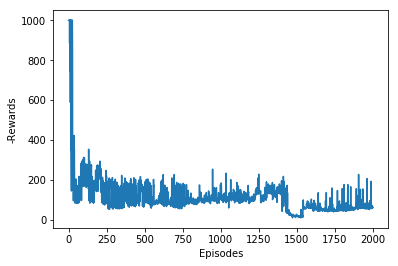

In [4]:
if __name__ == '__main__':
    MountainCarDemo(2000) 